In [1]:
import datetime as dt
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from matplotlib.animation import FuncAnimation
from operator import attrgetter
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

plt.ioff();

%matplotlib inline

# 1. Download and preprocess COVID data on Russia

In [2]:
# https://ourworldindata.org/coronavirus references owid/covid-19-data GitHub repo.
# So let's download directly file from repo, unless it already exists.
! wget -nc https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv

df = pd.read_csv('./owid-covid-data.csv')

File ‘owid-covid-data.csv’ already there; not retrieving.



In [3]:
def get_data_for_region(df, location, min_total_cases):
    # this query should also exclude rows with NaN total_cases
    df = df.query(f'location == "{location}" and total_cases >= {min_total_cases}')
    assert df['date'].is_monotonic, 'Rows for location {location} are not monotonic by date'

    min_date = dt.date.fromisoformat(df['date'].iloc[0])
    dates = df['date'].apply(dt.date.fromisoformat)
    return min_date, (dates - min_date).apply(attrgetter('days')).values, df['total_cases'].values


# min_total_cases=3 for Russia is equivalent to min_date=2020-03-03
min_date, X, y = get_data_for_region(df, 'Russia', min_total_cases=3)
assert min_date == dt.date(2020, 3, 3)

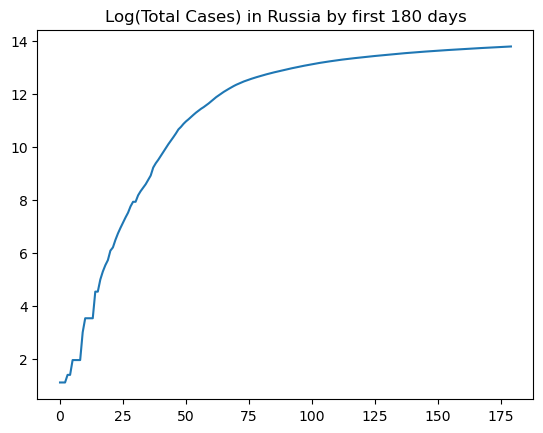

In [4]:
SHOW_FIRST_DAYS = 180

plt.title(f'Log(Total Cases) in Russia by first {SHOW_FIRST_DAYS} days')
plt.plot(np.arange(SHOW_FIRST_DAYS), np.log(y[:SHOW_FIRST_DAYS]));

In [5]:
TRAIN_FIRST_DAYS = 50

X_train, X_test = X[:TRAIN_FIRST_DAYS].reshape(-1, 1), X[TRAIN_FIRST_DAYS:].reshape(-1, 1)
y_train, y_test = y[:TRAIN_FIRST_DAYS], y[TRAIN_FIRST_DAYS:]

In [6]:
def fit_linear_regression_weights(X, y):
    linreg = LinearRegression().fit(X, y)
    return linreg.intercept_, linreg.coef_[0]


def predict(w, X):
    return w[1] * X + w[0]

# 2. Explore exponential models

## 2a. Train linear regression

Weights are (1.1934192756385702, 0.21410636658252818)


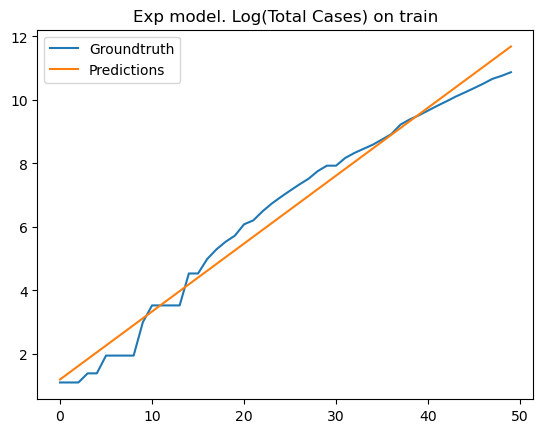

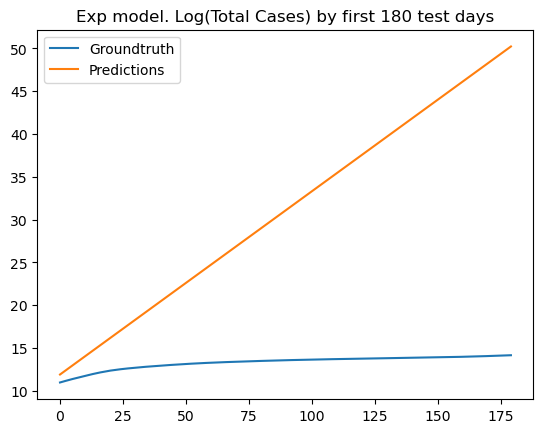

In [7]:
y_exp_train, y_exp_test = np.log(y_train), np.log(y_test)

w_exp = fit_linear_regression_weights(X_train, y_exp_train)
pred_exp_train = predict(w_exp, X_train)
pred_exp_test = predict(w_exp, X_test)

print('Weights are', w_exp)

plt.title('Exp model. Log(Total Cases) on train')
plt.plot(np.arange(y_exp_train.shape[0]), y_exp_train, label='Groundtruth')
plt.plot(np.arange(pred_exp_train.shape[0]), pred_exp_train, label='Predictions')
plt.legend()
plt.show()

plt.title(f'Exp model. Log(Total Cases) by first {SHOW_FIRST_DAYS} test days')
plt.plot(np.arange(SHOW_FIRST_DAYS), y_exp_test[:SHOW_FIRST_DAYS], label='Groundtruth')
plt.plot(np.arange(SHOW_FIRST_DAYS), pred_exp_test[:SHOW_FIRST_DAYS], label='Predictions')
plt.legend();

## 2b. Explore posterior distribution

In [8]:
sigma_exp_train = np.std(y_exp_train - pred_exp_train)
print(f'Estimated sigma of posterior distribution is {sigma_exp_train}')

Estimated sigma of posterior distribution is 4.392653043878289


In [9]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.concatenate(([1,], x.reshape(-1))).reshape(1, 2)
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )    
    return mu_n, sigma_n


def estimate_posterior_distribution(X, y, mu_prior, sigma_prior, sigma_noise):
    cur_mu, cur_sigma = mu_prior, sigma_prior
    limit = 3 * sigma_prior
    for xi, yi in zip(X, y):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, xi, yi, sigma_noise)
    return cur_mu, cur_sigma

mu_prior, sigma_prior = np.zeros(2), 100 * np.identity(2)
mu_post, sigma_post = estimate_posterior_distribution(X_train, y_exp_train, mu_prior, sigma_prior, sigma_noise=sigma_exp_train)
print('Mu', mu_post)
print('Sigma', sigma_post, sep='\n')

Mu [1.17589904 0.21463626]
Sigma
[[ 1.47609549 -0.04472995]
 [-0.04472995  0.00183276]]
